In [1]:
include("utils.jl")
using .Utils

In [2]:
using Flux
using LightGraphs
using GraphPlot
using Makie
using Colors
using ProgressMeter
using Statistics
using Distributions
using Random

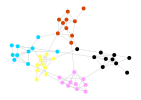

In [3]:
# Parameters
l = 5
k = 10
p_in = 0.4
p_out = 0.01
g = LightGraphs.SimpleGraphs.stochastic_block_model(
    p_in * (k - 1), p_out * k,
    k .* ones(UInt, l), seed = 6
)
communities = [c for c in 1:l for i in 1:k]
labels = Flux.onehotbatch(communities, 1:l)
multin = DiscreteUniform(5, 19)
# Flux.normalise
features = similar(labels, Float64)
for i in 1:size(features, 2)
    probs = softmax(convert(Array{Float64}, labels[:, i]))
    features[:, i] = rand(Multinomial(rand(multin), probs))
end
features = Utils.scale_center(features)

palette = distinguishable_colors(l)
colors = map(i -> getindex(palette, i), communities)
gplot(g, nodefillc = colors)

In [4]:
palette

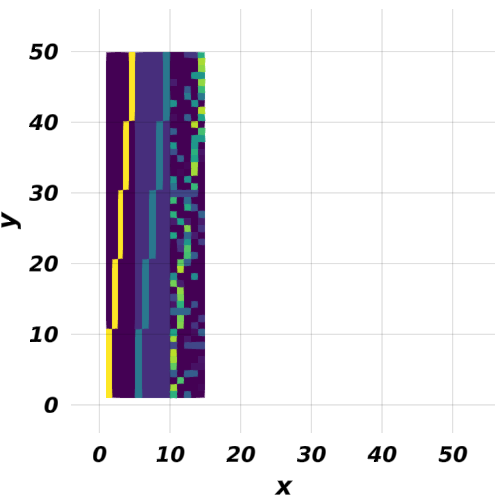

In [5]:
scene = Scene(resolution = (500, 500))
heatmap!(scene, 1:l, 1:(l*k),
    labels)
heatmap!(scene, l:(2*l), 1:(l*k),
    mapslices(softmax, convert(Array{Float64}, labels), dims = 1),
    colorrange = (0, 1))
heatmap!(scene, (2*l):(3*l), 1:(l*k),
    features,
    colorrange = (0, 1),
    limits = FRect(1, 1, l * k, l * k))

In [29]:
module Layers

include("utils.jl")
using Flux, LightGraphs, LinearAlgebra, .Utils

nobias(out::Integer) = fill(nothing, out)
Flux.param(n::AbstractArray{Nothing}) = 0

struct GC{T,U,F}
    Â::AbstractArray
    W::T
    b::U
    σ::F
    function GC(g::SimpleGraph, W::T, b::U, σ::F) where {T,U,F}
        Ã = Utils.adjacency_matrix_diag(g)
        Ãsumin_inv_sqrt = 1 ./ sqrt.(dropdims(sum(Ã, dims = 1), dims = 1))
        Ãsumout_inv_sqrt = 1 ./ sqrt.(dropdims(sum(Ã, dims = 2), dims = 2))
        Â = diagm(0 => Ãsumout_inv_sqrt) * Ã * diagm(0 => Ãsumin_inv_sqrt)
        new{T,U,F}(Â, W, b, σ)
    end
end

GC(g, W, b) = GC(g, W, b, identity)

function GC(g::SimpleGraph, in::Integer, out::Integer, σ = identity;
            initW = Flux.glorot_uniform, initb = zeros)
    return GC(g, param(initW(out, in)), param(initb(out)), σ)
end

Flux.@treelike GC

(a::GC)(x::AbstractArray) = a.σ.((a.W * x * a.Â) .+ a.b)

function Base.show(io::IO, l::GC)
    print(io, "GC(g ~ ", size(l.Â, 1), ", W ~ ", (size(l.W, 2), size(l.W, 1)), ", b ~ ")
    isa(l.b, TrackedArray) ? print(io, size(l.b, 1)) : print(io, "nothing")
    l.σ == identity || print(io, ", ", l.σ)
    print(io, ")")
end


struct Bilin{T,F}
    W::T
    σ::F
end

Bilin() = Bilin(identity)

function Bilin(in::Integer = nothing, σ = identity; initW = Flux.glorot_uniform)
    W = in == nothing ? 1 : param(initW(in, in))
    return Bilin(W, σ)
end

Flux.@treelike Bilin

(a::Bilin)(x::AbstractArray) = a.σ.(transpose(x) * a.W * x)


end

Main.Layers

In [30]:
import Statistics.mean

diml1 = 10  # Int64(round(l / 2))
dimξadj = 2
dimξfeat = 2
overlap = 2

# FIXME: unshare l1 once we do multitask
l1 = Layers.GC(g, l, diml1, Flux.relu, initb = Layers.nobias)
lμadj = Layers.GC(g, diml1, dimξadj, initb = Layers.nobias)
llogσadj = Layers.GC(g, diml1, dimξadj, initb = Layers.nobias)
lμfeat = Layers.GC(g, diml1, dimξfeat, initb = Layers.nobias)
llogσfeat = Layers.GC(g, diml1, dimξfeat, initb = Layers.nobias)

randn_like(target::A) where A<:AbstractArray{T} where T = randn(T, size(target))
mean(a::AbstractArray...) = sum(a) / length(a)

function voverlap(a, b, overlap)
    vcat(
        a[1:end-overlap, :],
        mean(a[end-overlap+1:end, :], b[1:overlap, :]),
        b[1+overlap:end, :]
    )
end

function enc(x)
    h = l1(x)
    (voverlap(lμadj(h), lμfeat(h), overlap), voverlap(llogσadj(h), llogσfeat(h), overlap))
end
sampleξ(μ, logσ) = μ .+ exp.(logσ) .* randn_like(μ)
dec = Chain(Dense(2, diml1, Flux.relu, initb = Layers.nobias),
            Layers.Bilin(diml1))

vae(x) = dec(sampleξ(enc(x)...))

vae (generic function with 1 method)

In [ ]:
vbox(
    scatter(embμ[1, :], embμ[2, :], color = colors, markersize = Utils.markersize(embμ)),
    heatmap(Array(adjacency_matrix(g)), colorrange = (0, 1)),
    heatmap(σ.(vae(features)).data, colorrange = (0, 1))
)

In [33]:
# TODO: check ref_api implementation details

Adiag = Utils.adjacency_matrix_diag(g)
densityA = mean(adjacency_matrix(g))

decregularizer(l = 0.01) = l * sum(x -> sum(x.^2), Flux.params(dec))

Lkl(μ, logσ) = 0.5 * sum(exp.(2 .* logσ) + μ.^2 .- 1 .- 2 .* logσ)
κkl = size(g, 1) * (dimξadj - overlap + dimξfeat)

Ladj(ξ) = (
    0.5 * sum(Utils.logitbinarycrossentropy.(dec(ξ), Adiag, pos_weight = (1 / densityA) - 1))
    / (1 - densityA)
)
κadj = size(g, 1)^2 * log(2)

#Lfeat(x) =

function loss(x; μlogσ = nothing, ξ = nothing, klscale = 0.01, regscale = 1.0)
    μ, logσ = something(μlogσ, enc(x))
    ξ = something(ξ, sampleξ(μ, logσ))
    klscale * Lkl(μ, logσ) / κkl + Ladj(ξ) / κadj + regscale * decregularizer()
end

loss (generic function with 1 method)

In [35]:
nepochs = 1000
history_Lkl = zeros(nepochs)
history_Ladj = zeros(nepochs)
history_loss = zeros(nepochs)

opt = ADAM(0.01)
@showprogress for i = 1:nepochs
    #@info "Epoch $i"
    Flux.train!(loss, Flux.params(l1, lμadj, llogσadj, lμfeat, llogσfeat, dec), zip([features]), opt)#, cb=evalcb)
    
    μ, logσ = enc(features)
    ξ = sampleξ(μ, logσ)
    history_Lkl[i] = Lkl(μ, logσ).data / κkl
    history_Ladj[i] = Ladj(ξ).data / κadj
    history_loss[i] = loss(features, μlogσ = (μ, logσ), ξ = ξ).data
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


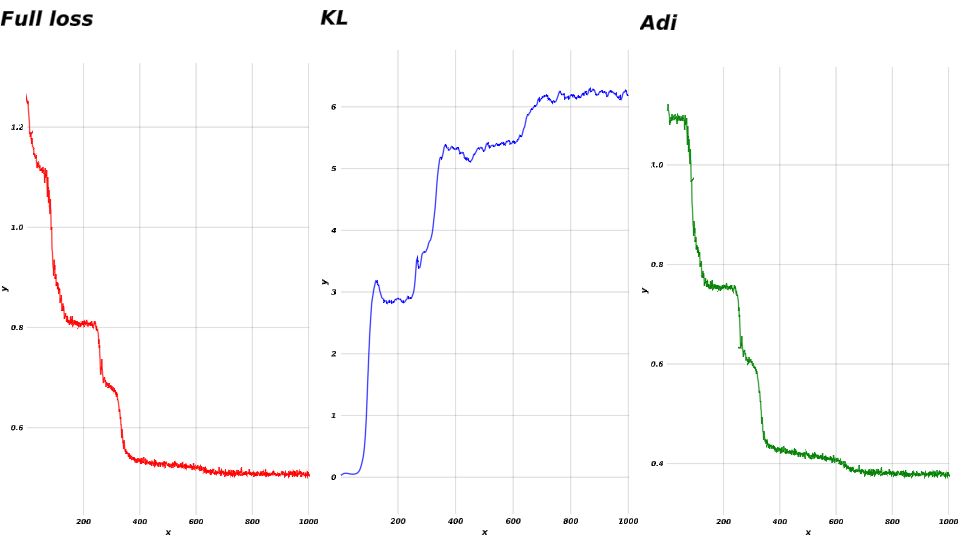

In [36]:
scene = Scene(resolution = (1000, 300))
theme = Theme(align = (:left, :bottom), raw = true, camera = campixel!)
vbox(
    hbox(lines(1:nepochs, history_loss, color = :red), text(theme, "Full loss")),
    hbox(lines(1:nepochs, history_Lkl, color = :blue), text(theme, "KL")),
    hbox(lines(1:nepochs, history_Ladj, color = :green), text(theme, "Adj"))
)

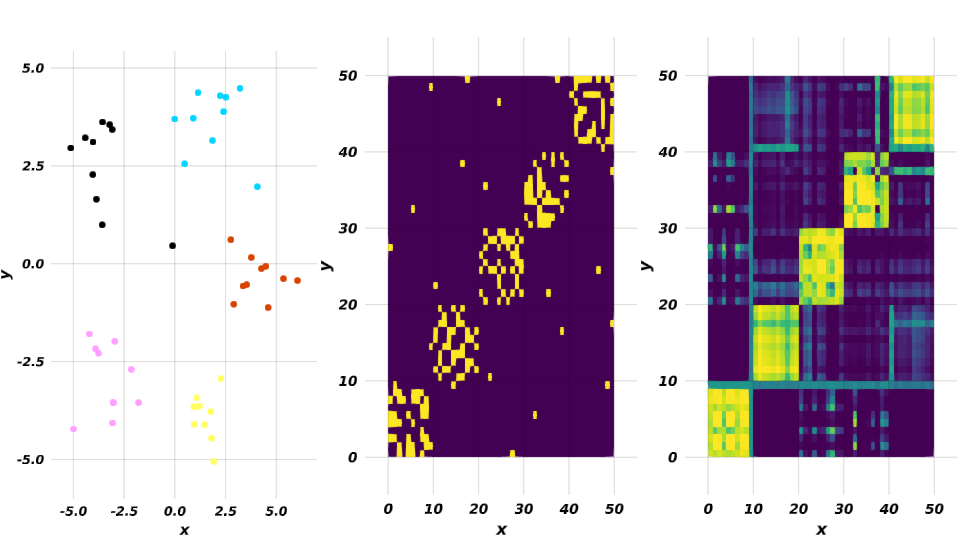

In [40]:
vbox(
    scatter(embμ[1, :], embμ[2, :], color = colors, markersize = Utils.markersize(embμ)),
    heatmap(Array(adjacency_matrix(g)), colorrange = (0, 1)),
    heatmap(σ.(vae(features)).data, colorrange = (0, 1))
)